<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/Analisis/Frecuencia%20inscripciones/NuevasInscripciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de inscripciones

## Importación de datos

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

# carga de archivo
raw_csv_data_CL = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CL.csv")
raw_csv_data_CO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CO.csv")
raw_csv_data_DO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_DO.csv")
raw_csv_data_EC = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_EC.csv")
raw_csv_data_MX = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_MX.csv")
raw_csv_data_PA = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PA.csv")
raw_csv_data_PE = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PE.csv")
raw_csv_data_SV = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_SV.csv")



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Estructura y formateo de datos

In [3]:
dateColumnName = "Fecha"
analizedValue = "cantidad"

unused_columns = ['cantidad','FuenteIngreso']

df_comp = pd.concat([raw_csv_data_CL, raw_csv_data_CO, raw_csv_data_DO, raw_csv_data_EC, raw_csv_data_MX, raw_csv_data_PA, raw_csv_data_PE, raw_csv_data_SV])

# formateo de fecha 
df_comp[dateColumnName] = pd.to_datetime(df_comp.Fecha, dayfirst = True)
df_comp = df_comp.groupby([dateColumnName,'FuenteIngreso']).sum().reset_index()
df_comp_UB = df_comp[df_comp.FuenteIngreso == "UB"]

df_comp_UB.set_index(dateColumnName, inplace=True, verify_integrity=True)
df_comp_UB=df_comp_UB.asfreq('d')
df_comp_UB=df_comp_UB.fillna(method='ffill')

df_comp_UB['analizedValue'] = df_comp_UB[analizedValue]

df_comp_UB = df_comp_UB.drop(unused_columns, axis=1)
df_comp_UB.head(5)

,analizedValue
Fecha,
2018-01-02,8
2018-01-03,20
2018-01-04,39
2018-01-05,55
2018-01-06,8


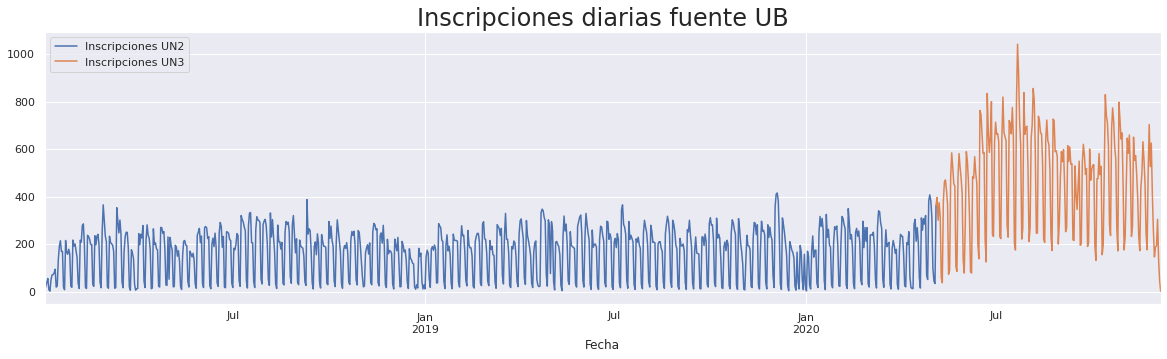

In [4]:
df_comp_UB.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones diarias fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

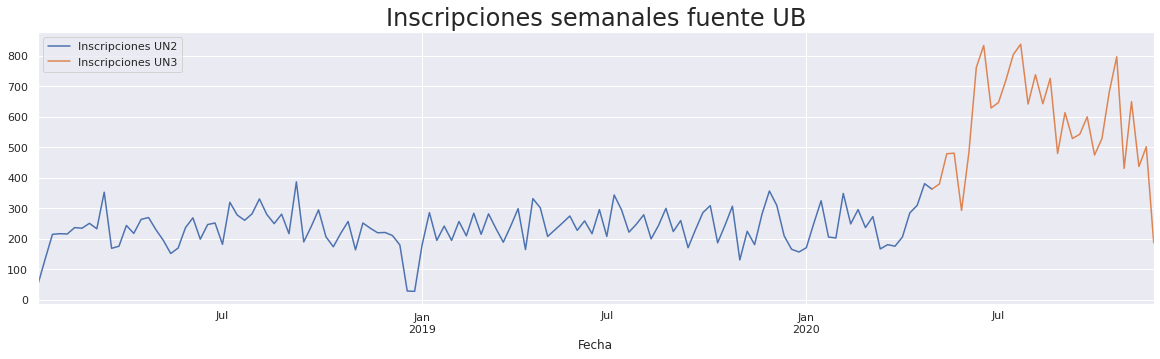

In [5]:
df_comp_UB_w=df_comp_UB.asfreq('W-Mon')

df_comp_UB_w.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB_w.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones semanales fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

## Prueba de estacionalidad

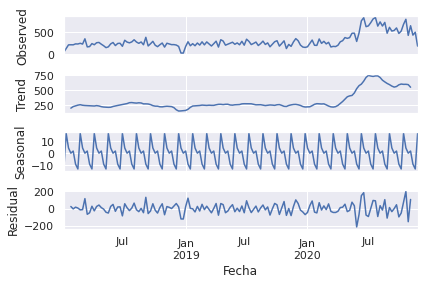

In [6]:
frecuencia = 6

s_dec_additive = seasonal_decompose(df_comp_UB_w.analizedValue, "additive", freq=frecuencia)
s_dec_additive.plot()
plt.show()

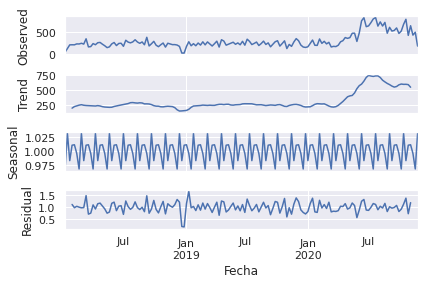

In [7]:
s_dec_multiplicative = seasonal_decompose(df_comp_UB_w.analizedValue, "multiplicative", freq=frecuencia)
s_dec_multiplicative.plot()
plt.show()

## División en entrenamiento y prueba

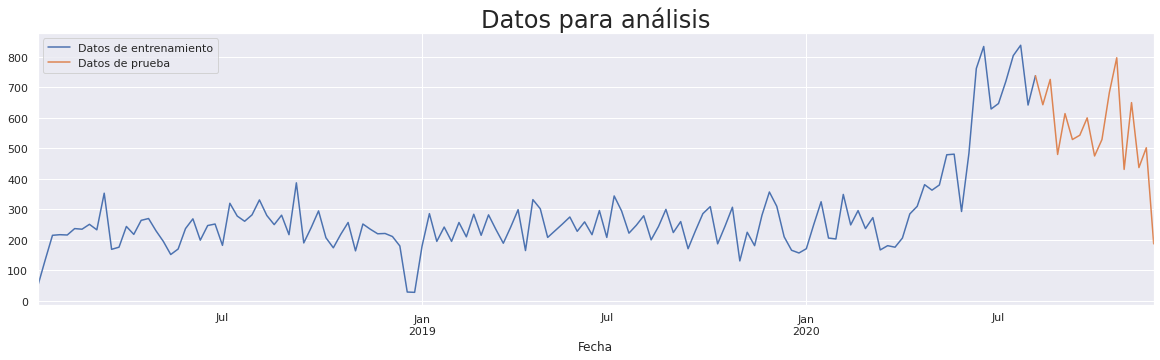

In [6]:
porcentajeEntrenamiento = 0.9
size = int(len(df_comp_UB_w)*porcentajeEntrenamiento)
df_train, df_test = df_comp_UB_w.iloc[:size], df_comp_UB_w.iloc[size-1:]

df_train.analizedValue.plot(figsize = (20,5), label='Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label='Datos de prueba')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con libreria Prophet

### Adecuación de datos

In [ ]:
import pandas as pd
from fbprophet import Prophet

dftrain_profet = df_train.reset_index()
dftrain_profet.columns = ['ds','y']
dftrain_profet['ds'] = pd.to_datetime(dftrain_profet['ds'])
dftrain_profet.sample(5)


,ds,y
1,2018-01-15,133
127,2020-06-15,762
53,2019-01-14,286
76,2019-06-24,296
4,2018-02-05,216


### Entrenamiento

In [ ]:
additiveModel = Prophet(interval_width=0.95, seasonality_mode='additive')
additiveModel.fit(dftrain_profet)

multiplicativeModel = Prophet(interval_width= 0.95, seasonality_mode='multiplicative')
multiplicativeModel.fit(dftrain_profet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Resultados modelo aditivo

In [ ]:
# Generar fechas futuras en base a los datos de prueba
future = additiveModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = additiveModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
148,2020-11-09,611.011733,420.861185,717.504559,602.320537,621.346312,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,0.0,0.0,0.0,565.320749
149,2020-11-16,618.163086,444.957308,735.261645,608.500214,629.405021,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,0.0,0.0,0.0,588.962825
150,2020-11-23,625.314440,480.488683,770.502484,614.356006,637.835617,5.709599,5.709599,5.709599,5.709599,5.709599,5.709599,0.0,0.0,0.0,631.024039
151,2020-11-30,632.465793,515.845609,798.918036,620.552071,645.670584,29.752270,29.752270,29.752270,29.752270,29.752270,29.752270,0.0,0.0,0.0,662.218062
152,2020-12-07,639.617146,500.627388,804.541742,626.799206,654.163020,11.289907,11.289907,11.289907,11.289907,11.289907,11.289907,0.0,0.0,0.0,650.907053


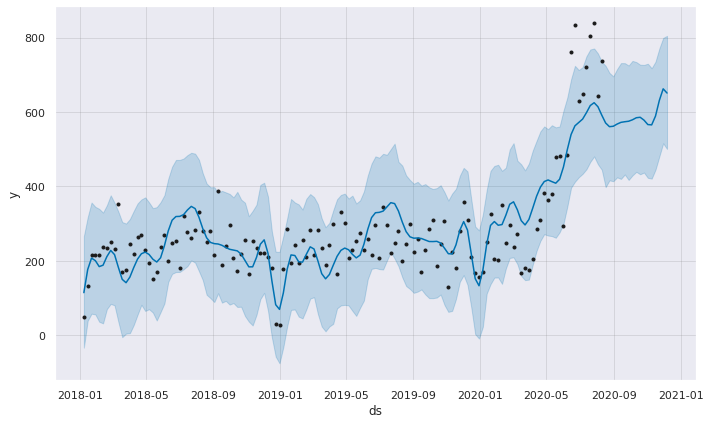

In [ ]:
additiveModel.plot(forecast);

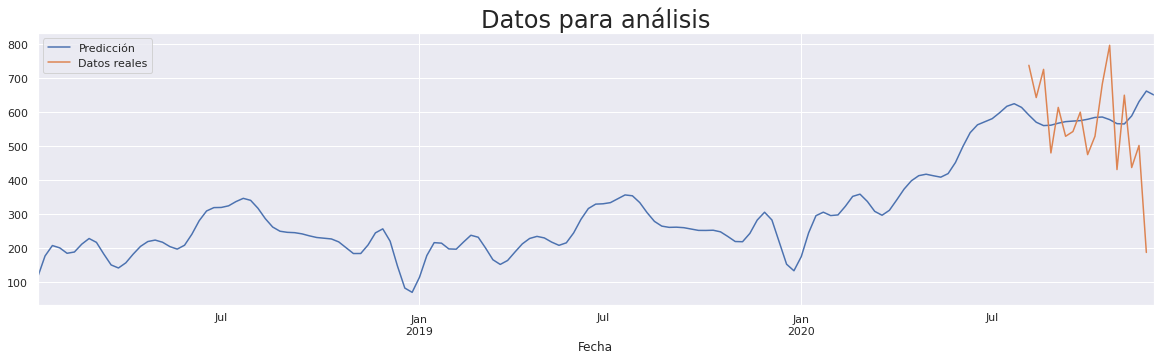

In [ ]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

### Resultados modelo multiplicativo

In [ ]:
# Generar fechas futuras en base a los datos de prueba
future = multiplicativeModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = multiplicativeModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
148,2020-11-09,578.200828,349.160420,587.508119,569.235130,587.135916,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,0.0,0.0,0.0,464.686250
149,2020-11-16,584.473033,384.539310,637.654462,574.455571,594.183844,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,0.0,0.0,0.0,514.610244
150,2020-11-23,590.745237,477.244694,726.202565,579.651193,601.604836,0.018187,0.018187,0.018187,0.018187,0.018187,0.018187,0.0,0.0,0.0,601.489341
151,2020-11-30,597.017441,545.348836,786.657638,584.662263,608.648235,0.108557,0.108557,0.108557,0.108557,0.108557,0.108557,0.0,0.0,0.0,661.827969
152,2020-12-07,603.289645,500.676625,755.884587,589.665991,615.906097,0.040633,0.040633,0.040633,0.040633,0.040633,0.040633,0.0,0.0,0.0,627.803264


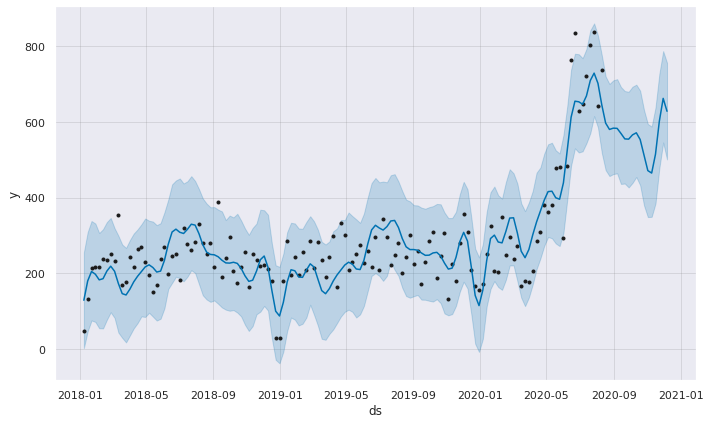

In [ ]:
multiplicativeModel.plot(forecast);

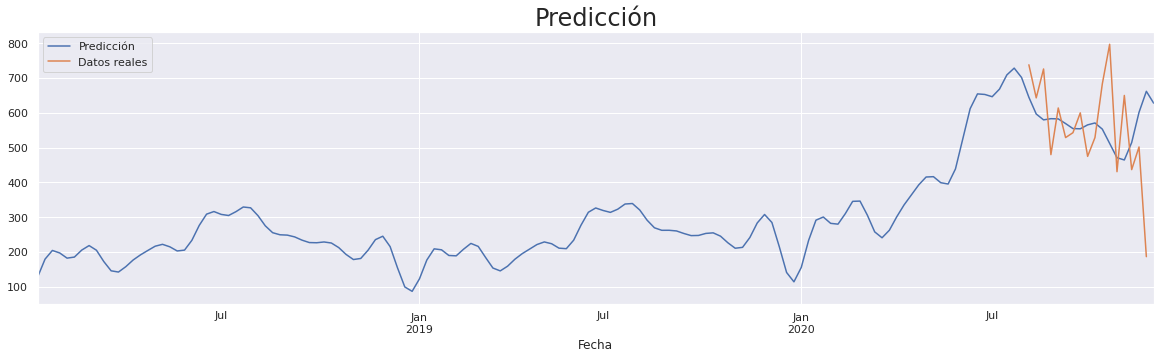

In [ ]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Predicción", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con RNN

### Escalado de datos

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# escalado con el conjunto total de datos
scaler.fit(df_comp_UB_w)

scaled_train = scaler.transform(df_train)
scaled_test = scaler.transform(df_test)


### Modelo 1: Con una sola capa

#### Creación del modelo con gridsearch

Para optimización de hiperparametros

In [12]:
from math import sqrt
from numpy import mean
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
  periodosTotales = len(data)
  X_train = []
  y_train = []

  for i in range(n_in, periodosTotales):
      X_train.append(scaled_train[i-n_in:i, 0])
      y_train.append(scaled_train[i, 0])
  X_train, y_train = np.array(X_train), np.array(y_train)
  # Se agrega nueva dimension a la matriz en caso de colocar mas variables al modelo
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_out))
  return X_train, y_train

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, opt = config
	# transform series into supervised format
	train_x, train_y = series_to_supervised(train, n_in=n_input)
	# define model
	model = Sequential()
	model.add(LSTM(units=n_nodes, return_sequences = False, activation='relu', input_shape=(n_input, 1)))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer=opt)
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  n_input, n_nodes, n_epochs, n_batch, opt = cfg
  predictions = list()
  train, test = data[0], data[1]
	# fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  first_eval_batch = train[-n_input:]
  current_batch = first_eval_batch.reshape((1, n_input, 1))
  test_predictions = []
  for i in range(len(df_test)):      
      # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
      current_pred = model.predict(current_batch)[0]      
      # guardar la predicción
      test_predictions.append(current_pred)
      # actualizar el lote para incluir ahora la predicción y soltar primer valor
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
  # Conversion de datos escalados al valor original
  true_predictions = scaler.inverse_transform(test_predictions)
  error = measure_rmse(test, true_predictions)
  print(' > %.3f' % error)
  return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [4,8,10,12]
	n_nodes = [10, 50, 100]
	n_epochs = [100, 200, 300]
	n_batch = [10, 20, 50]
	optimizers = ['adam', 'rmsprop','SGD']
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for opt in optimizers:
						cfg = [i, j, k, l, opt]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs
#'binary_crossentropy'
n_test = 12
# model configs
cfg_list = model_configs()

data = [scaled_train, df_test]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:5]:
	print(cfg, error)

Total configs: 324
 > 392.489
 > 465.698
 > 335.853
 > 318.559
 > 1030.608
 > 722.676
 > 6479.664
 > 530.868
 > 3507.461
 > 3580.096
> Model[[4, 10, 100, 10, 'adam']] 1736.397
 > 2686.580
 > 438.396
 > 1279.955
 > 875.875
 > 2227.215
 > 397.724
 > 563.681
 > 4509.516
 > 10664.326
 > 4359.023
> Model[[4, 10, 100, 10, 'rmsprop']] 2800.229
 > 256.881
 > 234.526
 > 137.459
 > 272.197
 > 301.923
 > 124.919
 > 292.110
 > 250.695
 > 288.903
 > 288.036
> Model[[4, 10, 100, 10, 'SGD']] 244.765
 > 570.406
 > 899.286
 > 782.268
 > 425.926
 > 3798.364
 > 771.628
 > 680.156
 > 379.650
 > 268.124
 > 359.569
> Model[[4, 10, 100, 20, 'adam']] 893.538
 > 1643.337
 > 498.982
 > 2307.389
 > 450.077
 > 841.217
 > 1123.206
 > 1752.262
 > 457.042
 > 370.177
 > 2964.010
> Model[[4, 10, 100, 20, 'rmsprop']] 1240.770
 > 293.476
 > 272.421
 > 289.415
 > 315.680
 > 209.961
 > 269.214
 > 304.884
 > 314.236
 > 288.905
 > 314.638
> Model[[4, 10, 100, 20, 'SGD']] 287.283
 > 582.318
 > 178.404
 > 569.389
 > 198.898
 

#### Resultados de modelo óptimo

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

'''
[4, 50, 300, 10, 'SGD'] 131.91979679266768
[8, 100, 300, 20, 'SGD'] 138.0241353314562
[10, 100, 300, 20, 'SGD'] 139.50798378464373
[4, 100, 300, 10, 'SGD'] 146.63703429883515
[8, 50, 300, 20, 'SGD'] 147.65229198280147
'''

n_input = 8
n_features = 1
n_nodes = 100
optimizer = 'SGD'
lossFunction = 'mse'
n_epochs = 300
batch_size = 20

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
print(len(generator))

# creacion del modelo
model = Sequential()
#Primera capa
model.add(LSTM(units=n_nodes, return_sequences = False, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(loss=lossFunction, optimizer=optimizer, metrics = ['accuracy'])

# entrenamiento
model.fit_generator(generator,epochs=n_epochs, steps_per_epoch= batch_size)

128
Epoch 1/300
20/20 [==============================] - 1s 4ms/step - loss: 0.0605 - accuracy: 0.0443
Epoch 2/300
20/20 [==============================] - 0s 4ms/step - loss: 0.1095 - accuracy: 0.0000e+00
Epoch 3/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0207 - accuracy: 0.0000e+00
Epoch 4/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0184 - accuracy: 0.0342
Epoch 5/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0219 - accuracy: 0.0000e+00
Epoch 6/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0553 - accuracy: 0.0000e+00
Epoch 7/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0137 - accuracy: 0.0000e+00
Epoch 8/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0216 - accuracy: 0.0390
Epoch 9/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0235 - accuracy: 0.0390
Epoch 10/300
20/20 [==============================] - 0s 4ms/step - loss: 0.0126 - ac

#### Analisis de errores

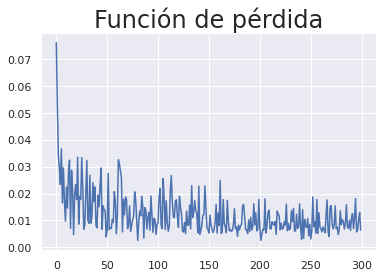

In [83]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title("Función de pérdida", size= 24)
plt.show()

In [85]:
# concatena dataset de entrenamiento y prueba
dataset_total = pd.concat((df_train['analizedValue'], df_test['analizedValue']), axis = 0)
indiceInicialEntrenamiento = len(dataset_total) - len(df_test) - n_input

# se utilizan los ultimos registros del año anterior para predecir el primer mes futuro  
inputs = dataset_total[indiceInicialEntrenamiento:].values
inputs = inputs.reshape(-1,1) # se agrega una columna adicional
inputs = scaler.transform(inputs) # se escalan los valores
X_test = []

cantidadRegistrosPrueba = len(df_test)

for i in range(n_input,  n_input + cantidadRegistrosPrueba):
    X_test.append(inputs[i-n_input:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# prediccion con el modelo generado
predict = model.predict(X_test)

# se regresan al valor original los datos transformados en las predicciones
predict = scaler.inverse_transform(predict)

# Error cuadratico medio
rmse = math.sqrt(mean_squared_error(df_test.iloc[:].values, predict))
rango = max(df_test.iloc[:].values) - min(df_test.iloc[:].values)
rmse2 = rmse/rango
print('Error cuadratico medio: %.3f' % rmse2)

Error cuadratico medio: 0.311


#### Comparación con datos de prueba

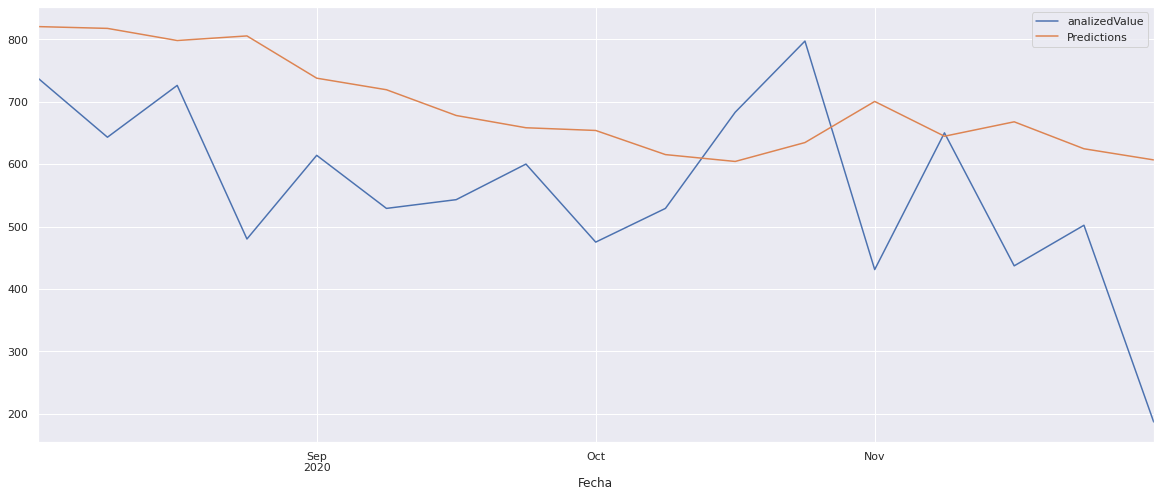

In [86]:
result = df_test.copy()
result['Predictions'] = predict
result.plot(figsize=(20,8))